In [10]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import json
import torch
import math
import einops

import experiment
from utils.config import ExperimentConfig    
from utils.loss_fn import EmpiricalCRPS, NormalCRPS
from utils.NinoData import NinoData, NinoDataLENS
from torch.utils.data import DataLoader
from torch.nn.attention import SDPBackend, sdpa_kernel


In [11]:
mpl.rcParams['figure.dpi'] = 300            # High resolution
mpl.rcParams['font.size'] = 9               # or 10, depending on guidelines
mpl.rcParams['axes.linewidth'] = 0.5        # Axis line thickness
mpl.rcParams['lines.linewidth'] = 1.0       # Default plot line thickness
mpl.rcParams['legend.fontsize'] = 7         # Legend font size

In [12]:
ds_n = "godas"

In [13]:
eval_data = xr.open_zarr(f"2025-01-27_10-54-36_1092050_{ds_n}_eval.zarr")
eval_data = eval_data.sel(time = slice("1700", "2010"), lat = slice(-20., 20.), lon = slice(90, 270))
eval_data = eval_data * -1

In [14]:
def crps_gaussian(x: np.ndarray, mu: np.ndarray, std: np.ndarray) -> np.ndarray:
    from scipy.special import erf
    """CRPS for Gaussian distribution.

    Args:
        x (np.ndarray): Ground truth data of size (n_samples, n_features)
        mu (np.ndarray): Mean of size (n_samples, n_features)
        std (np.ndarray): Standard deviation of size (n_samples, n_features)

    Returns:
        crps (np.ndarray): CRPS of size (n_samples, n_features) 
    """
    sqrtPi = np.sqrt(np.pi)
    z = (x - mu) / std 
    phi = np.exp(-z ** 2 / 2) / (np.sqrt(2) * sqrtPi) #standard normal pdf
    crps = std * (z * erf(z / np.sqrt(2)) + 2 * phi - 1 / sqrtPi) #crps as per Gneiting et al 2005
    return crps 

def compute_rank_histogram(obs, ens):
    """
    Compute the rank histogram for a set of observations and ensemble forecasts.
    
    Parameters
    ----------
    obs : ndarray of shape (M,)
        The observations, flattened along all spatial/temporal dimensions.
    ens : ndarray of shape (M, N)
        The ensemble forecasts, where M is the total number of samples
        and N is the number of ensemble members.

    Returns
    -------
    ranks : ndarray of shape (N+1,)
        The rank histogram counts for ranks from 0 to N.
    """
    M, N = ens.shape
    # Initialize counts for each possible rank: 0..N
    rank_counts = np.zeros(N + 1, dtype=np.int64)

    # For each sample, compute how many ensemble members are less than obs
    # This integer is the rank of obs in the sorted ensemble.
    # rank = 0 means obs is smaller than all ensemble members,
    # rank = N means obs is larger than all ensemble members.
    for i in range(M):
        rank = np.sum(ens[i, :] < obs[i])
        rank_counts[rank] += 1

    return rank_counts / M

In [15]:
lsm = eval_data.temp_ocn_0a_tgt.isel(time = 0, lag = 0) != 0
lsm = lsm.rename("lsm")
del lsm["time"]
del lsm["lag"]
del lsm["month"]
eval_data = xr.merge([eval_data, lsm]).compute()

In [16]:
num_predictors = len(eval_data.ens)

filtered_tgt = eval_data.temp_ocn_0a_tgt.where(eval_data.lsm)
filtered_pred = eval_data.temp_ocn_0a_pred.where(eval_data.lsm)

filtered_mean = filtered_pred.mean("ens") 
filtered_std = filtered_pred.std("ens") 
filtered_var = filtered_pred.var("ens") 

filtered_tgt_nino4 = filtered_tgt.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"]).rolling(time = 3).mean()
filtered_pred_nino4 = filtered_pred.sel(lat = slice(-5, 5), lon = slice(190, 240)).mean(dim = ["lat", "lon"]).rolling(time = 3).mean()
filtered_mean_nino4 = filtered_pred_nino4.mean("ens") 
filtered_std_nino4 = filtered_pred_nino4.std("ens") 
filtered_var_nino4 = filtered_pred_nino4.var("ens") 

In [17]:
# 2) Define the lags you want to plot
lags_to_plot = [1, 6, 12, 18, 24]
n = len(lags_to_plot)

# 3) Create a color gradient from bright green (#00FF00) to dark green (#006400)
bright_hex = '#00FF00'
dark_hex   = '#006400'

green_gradient = []
for idx in range(n):
    alpha = idx / (n - 1)  # Goes from 0 to 1 as we move through lags
    # Linear interpolation between bright_green and dark_green
    green = [
        (1 - alpha) * mcolors.to_rgb(bright_hex)[ch] + alpha * mcolors.to_rgb(dark_hex)[ch]
        for ch in range(3)
    ]
    green_gradient.append(mcolors.to_hex(green))

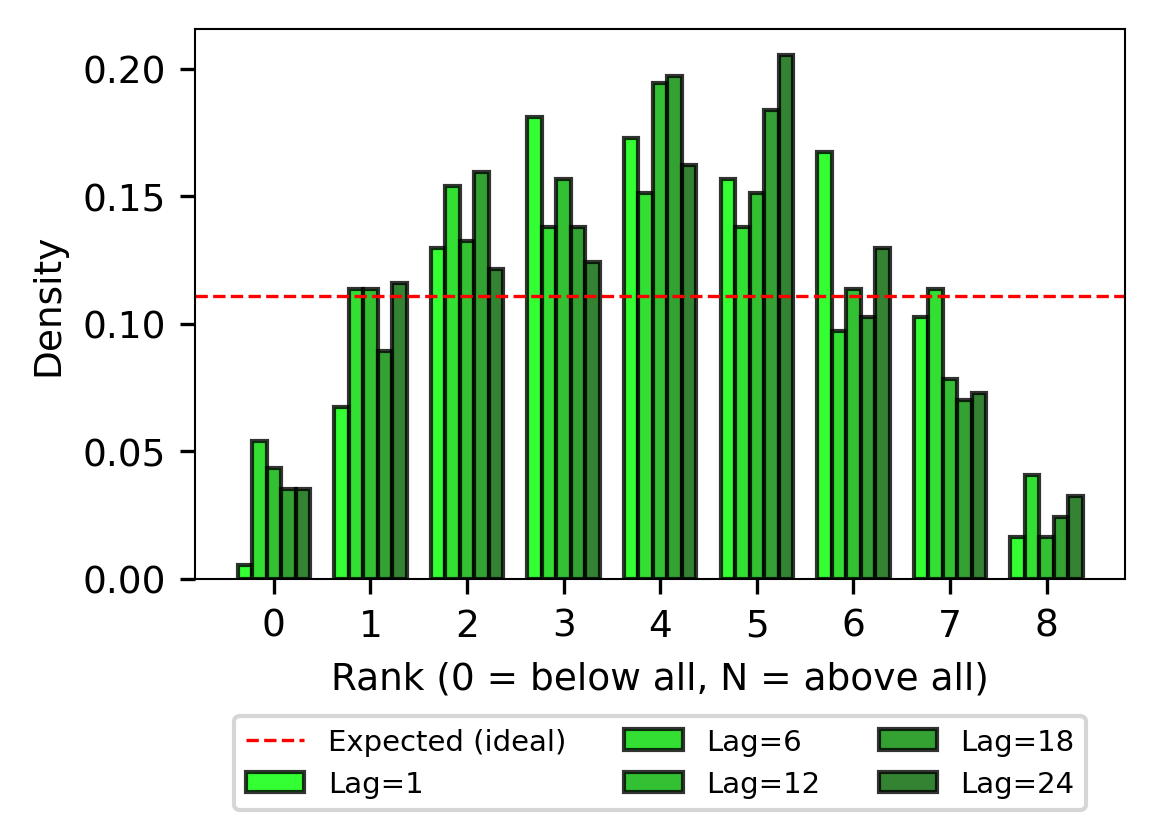

In [18]:
# 2) Create a single figure and axis
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust as needed

# 3) Loop over each representative lag and plot on the same axis
width = 0.15  # Bar width offset (adjust so bars don’t overlap)
colors = green_gradient  # Use the green gradient defined above

for i, lag_val in enumerate(lags_to_plot):
    # Select data for this lag
    obs_da = filtered_tgt_nino4.sel(lag=lag_val)
    ens_da = filtered_pred_nino4.sel(lag=lag_val)

    # 2. Convert xarray DataArray to numpy arrays
    obs = obs_da.values  # shape (M,)
    ens = ens_da.values  # shape (M, N)
    
    # Mask NaNs
    valid_mask = (~np.isnan(obs)) & (~np.isnan(ens).any(axis=1))
    obs_valid = obs[valid_mask]
    ens_valid = ens[valid_mask, :]
    
    # Compute rank histogram
    rank_counts = compute_rank_histogram(obs_valid, ens_valid)
    N = ens_valid.shape[1]  # number of ensemble members
    bins = np.arange(N + 1)
    
    # Offset each lag’s bars horizontally: bins + i*width
    ax.bar(bins + i * width,
           rank_counts,
           width=width,
           alpha=0.8,
           color=colors[i],
           edgecolor="black",
           label=f"Lag={lag_val}")

# 4) Final formatting
ax.set_ylabel("Density")
ax.set_xlabel("Rank (0 = below all, N = above all)")

# Optionally draw a reference line for a uniform distribution
# The expected count for a perfectly flat histogram:
expected_count = rank_counts.sum() / (N + 1)
ax.axhline(expected_count, color="red", linestyle="dashed", linewidth=0.8,
           label="Expected (ideal)")

# Position x-ticks in the middle of each "cluster"
ax.set_xticks(bins + (len(lags_to_plot)-1)*width/2)
ax.set_xticklabels(bins)

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)


plt.tight_layout()
plt.savefig("rank_histogram_nino4.png")
plt.show()


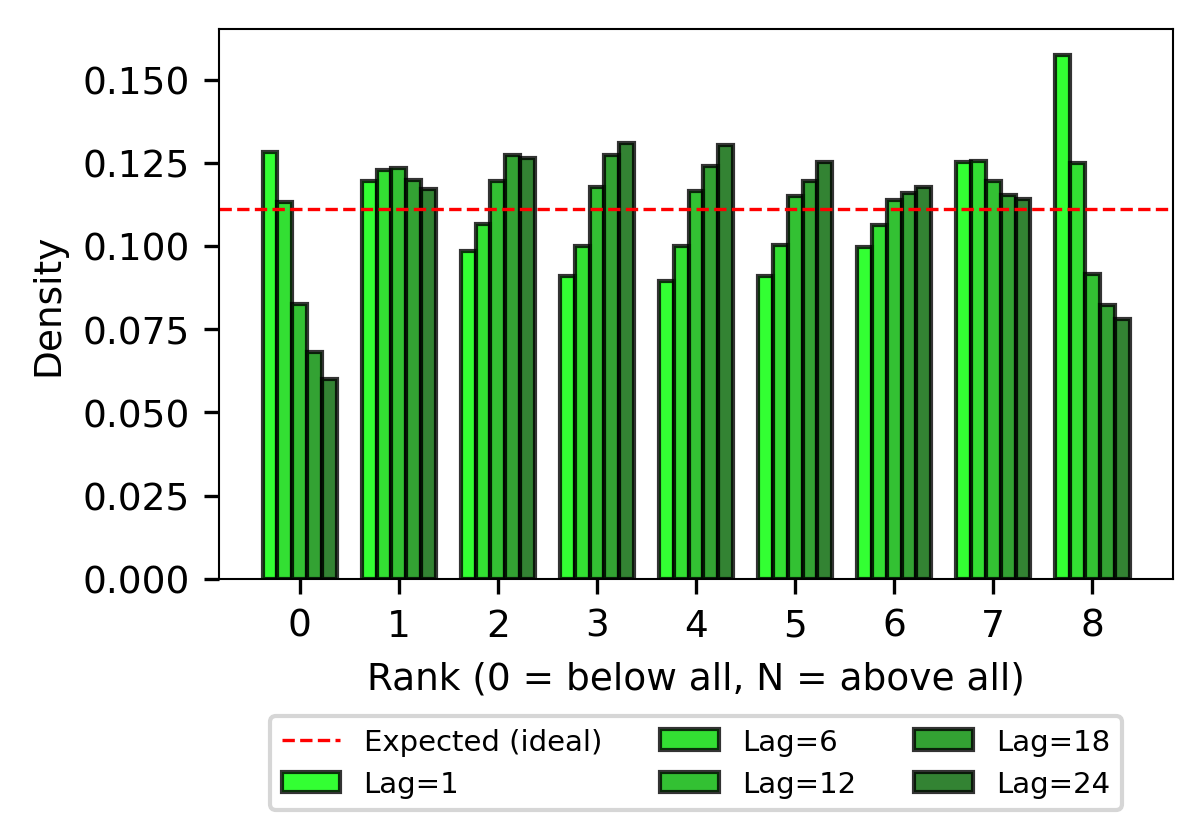

In [19]:
# 2) Create a single figure and axis
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust as needed

# 3) Loop over each representative lag and plot on the same axis
width = 0.15  # Bar width offset (adjust so bars don’t overlap)
colors = green_gradient  # Use the green gradient defined above

for i, lag_val in enumerate(lags_to_plot):
    # Select data for this lag
    obs_da = filtered_tgt.sel(lag=lag_val).stack(sample=("time", "lat", "lon"))  # shape: (sample,)
    ens_da = filtered_pred.sel(lag=lag_val).stack(sample=("time", "lat", "lon")) # shape: (ens, sample)

    # Transpose `ens_da` so it's (sample, ens).
    ens_da = ens_da.transpose("sample", "ens")  # shape: (sample, ens)

    # 2. Convert xarray DataArray to numpy arrays
    obs = obs_da.values  # shape (M,)
    ens = ens_da.values  # shape (M, N)
    
    # Mask NaNs
    valid_mask = (~np.isnan(obs)) & (~np.isnan(ens).any(axis=1))
    obs_valid = obs[valid_mask]
    ens_valid = ens[valid_mask, :]
    
    # Compute rank histogram
    rank_counts = compute_rank_histogram(obs_valid, ens_valid)
    N = ens_valid.shape[1]  # number of ensemble members
    bins = np.arange(N + 1)
    
    # Offset each lag’s bars horizontally: bins + i*width
    ax.bar(bins + i * width,
           rank_counts,
           width=width,
           alpha=0.8,
           color=colors[i],
           edgecolor="black",
           label=f"Lag={lag_val}")

# 4) Final formatting
ax.set_ylabel("Density")
ax.set_xlabel("Rank (0 = below all, N = above all)")

# Optionally draw a reference line for a uniform distribution
# The expected count for a perfectly flat histogram:
expected_count = rank_counts.sum() / (N + 1)
ax.axhline(expected_count, color="red", linestyle="dashed", linewidth=0.8,
           label="Expected (ideal)")

# Position x-ticks in the middle of each "cluster"
ax.set_xticks(bins + (len(lags_to_plot)-1)*width/2)
ax.set_xticklabels(bins)

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)


plt.tight_layout()
plt.savefig(f"rank_histogram_ssta_{ds_n}.png")
plt.show()


In [20]:
monthly_accs, monthly_rmse, monthly_crps, monthly_ssr = [], [], [], []
monthly_nino_accs, monthly_nino_rmse, monthly_nino_crps, monthly_nino_ssr = [], [], [], []

clim_rmse, clim_crps = [], []
clim_nino_rmse, clim_nino_crps = [], []

for month in range(1, 13):
    # 1. Select the data for the month and stack the spatial dimensions
    tgt = filtered_tgt.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    mean = filtered_mean.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    std = filtered_std.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    var = filtered_var.sel(time = filtered_mean["time.month"] == month).stack(space=("lat", "lon"))
    # 1.1 For nino4 we don't need to stack space
    tgt_nino4 = filtered_tgt_nino4.sel(time = filtered_mean["time.month"] == month)
    mean_nino4 = filtered_mean_nino4.sel(time = filtered_mean["time.month"] == month)
    std_nino4 = filtered_std_nino4.sel(time = filtered_mean["time.month"] == month)
    var_nino4 = filtered_var_nino4.sel(time = filtered_mean["time.month"] == month)
    # 1. Compute climatology statistics
    clim_da_mean = tgt.mean("time")
    clim_da_std = tgt.std("time")

    clim_nino_mean = tgt_nino4.mean("time")
    clim_nino_std = tgt_nino4.std("time")
    
    # 2. Compute CRPS for each sample
    crps = crps_gaussian(x = tgt, mu = mean, std = std)  # shape (time, lag, space)
    monthly_crps += [crps.mean(["space", "time"])]
    crps_nino4 = crps_gaussian(tgt_nino4, mean_nino4, std_nino4) # shape (time, lag)
    monthly_nino_crps += [crps_nino4.mean("time")]
    crps_clim = crps_gaussian(tgt, clim_da_mean, clim_da_std)
    clim_crps += [crps_clim.mean(["space", "time"])]
    crps_clim_nino4 = crps_gaussian(tgt_nino4, clim_nino_mean, clim_nino_std)
    clim_nino_crps += [crps_clim_nino4.mean("time")]
    # 3. Compute RMSE for each sample
    rmse = np.sqrt(((tgt - mean)**2).mean(["space", "time"]))
    rmse_nino4 = np.sqrt(((tgt_nino4 - mean_nino4)**2).mean("time"))
    monthly_rmse.append(rmse)
    monthly_nino_rmse.append(rmse_nino4)
    clim_rmse.append(np.sqrt(((tgt - clim_da_mean)**2).mean(["space", "time"])))
    clim_nino_rmse.append(np.sqrt(((tgt_nino4 - clim_nino_mean)**2).mean("time")))
    # 4. Compute skill scores (ACC, PCC)
    acc = (tgt * mean).sum(["space", "time"]) / (((tgt ** 2).sum(["space", "time"]) ** 0.5) * (mean ** 2).sum(["space", "time"]) ** 0.5)
    pcc = (tgt_nino4 * mean_nino4).sum("time") / (((tgt_nino4 ** 2).sum("time") ** 0.5) * (mean_nino4 ** 2).sum("time") ** 0.5)
    monthly_accs += [acc]
    monthly_nino_accs += [pcc]
    # 5. Compute spread skill score
    ssr = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var.mean(["time", "space"])) / rmse
    ssr_nino4 = np.sqrt((num_predictors +1 ) / num_predictors) * np.sqrt(var_nino4.mean("time")) / rmse_nino4
    monthly_ssr += [ssr]
    monthly_nino_ssr += [ssr_nino4]

monthly_rmse = xr.concat(monthly_rmse, dim = "month")
monthly_nino_rmse = xr.concat(monthly_nino_rmse, dim = "month")
clim_rmse = xr.concat(clim_rmse, dim = "month")
clim_nino_rmse = xr.concat(clim_nino_rmse, dim = "month")
monthly_accs = xr.concat(monthly_accs, dim = "month")
monthly_nino_accs = xr.concat(monthly_nino_accs, dim = "month")
monthly_crps = xr.concat(monthly_crps, dim = "month")
monthly_nino_crps = xr.concat(monthly_nino_crps, dim = "month")
clim_crps = xr.concat(clim_crps, dim = "month")
clim_nino_crps = xr.concat(clim_nino_crps, dim = "month")
monthly_ssr = xr.concat(monthly_ssr, dim = "month")
monthly_nino_ssr = xr.concat(monthly_nino_ssr, dim = "month")

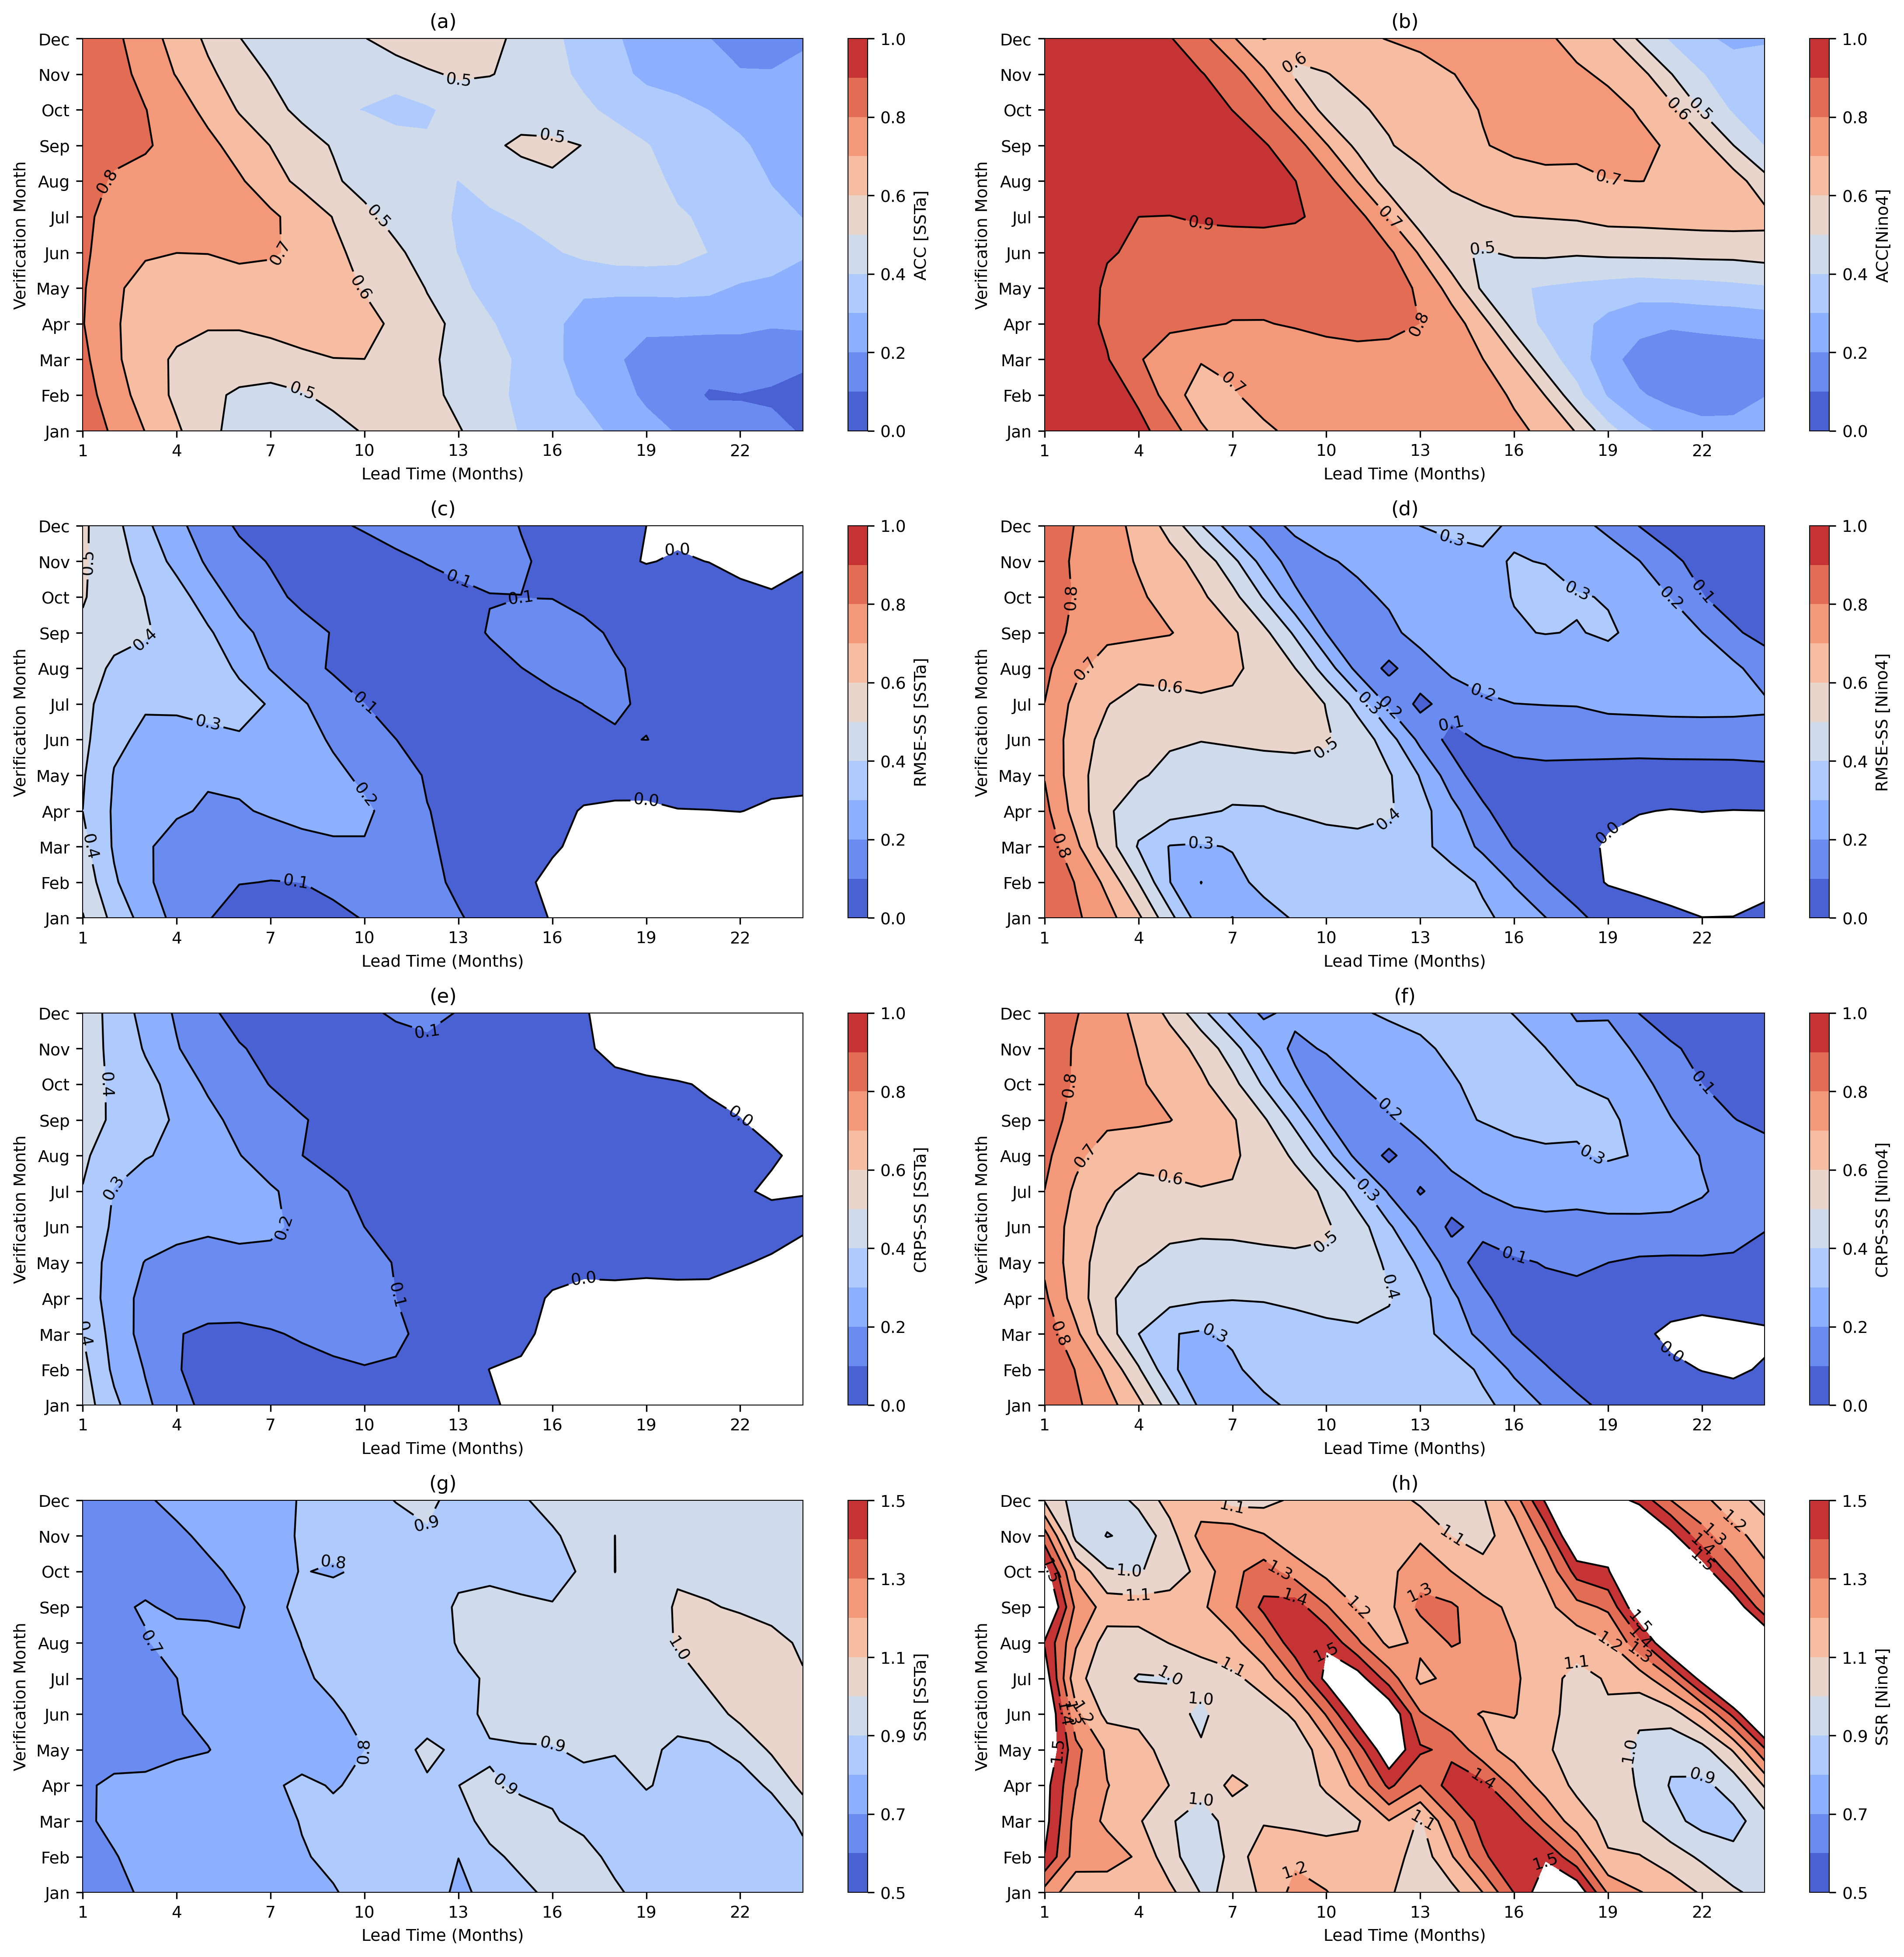

In [21]:
lev = np.linspace(0., 1., 11)
rmse_ss = (1 - monthly_rmse/clim_rmse)
nino_ss = (1 - monthly_nino_rmse/clim_nino_rmse)
crps_ss = (1 - monthly_crps/clim_crps)
nino_crps_ss = (1 - monthly_nino_crps/clim_nino_crps)

cmap = "coolwarm"

plt.figure(figsize = (15, 15))
plt.subplot(4, 2, 1)
filled = plt.contourf(monthly_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(a)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC [SSTa]")
plt.subplot(4, 2, 2)
filled = plt.contourf(monthly_nino_accs.values, cmap = cmap, levels = lev)
contours = plt.contour(monthly_nino_accs.values, levels = np.linspace(0.5, 1, 6), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(b)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "ACC[Nino4]")

plt.subplot(4, 2, 3)
filled = plt.contourf(rmse_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(rmse_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(c)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [SSTa]")
plt.subplot(4, 2, 4)
filled = plt.contourf(nino_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(d)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "RMSE-SS [Nino4]")

plt.subplot(4, 2, 5)
filled = plt.contourf(crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(e)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [SSTa]")
plt.subplot(4, 2, 6)
filled = plt.contourf(nino_crps_ss.values, cmap = cmap, levels = lev)
contours = plt.contour(nino_crps_ss.values, levels = lev, colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(f)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "CRPS-SS [Nino4]")

plt.subplot(4, 2, 7)
filled = plt.contourf(monthly_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(g)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [SSTa]")
plt.subplot(4, 2, 8)
filled = plt.contourf(monthly_nino_ssr.values, cmap = cmap, levels = np.linspace(0.5, 1.5, 11))
contours = plt.contour(monthly_nino_ssr.values, levels = np.linspace(0.5, 1.5, 11), colors = "black")
plt.clabel(contours, inline=True, fontsize=9)
plt.title("(h)")
plt.ylabel("Verification Month")
plt.xlabel("Lead Time (Months)")
plt.xticks(np.arange(0, 24, 3),np.arange(1,25)[::3])
plt.yticks(np.arange(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.colorbar(filled, label = "SSR [Nino4]")
plt.tight_layout()

plt.savefig(f"monthly_scores_{ds_n}.png")
plt.show()

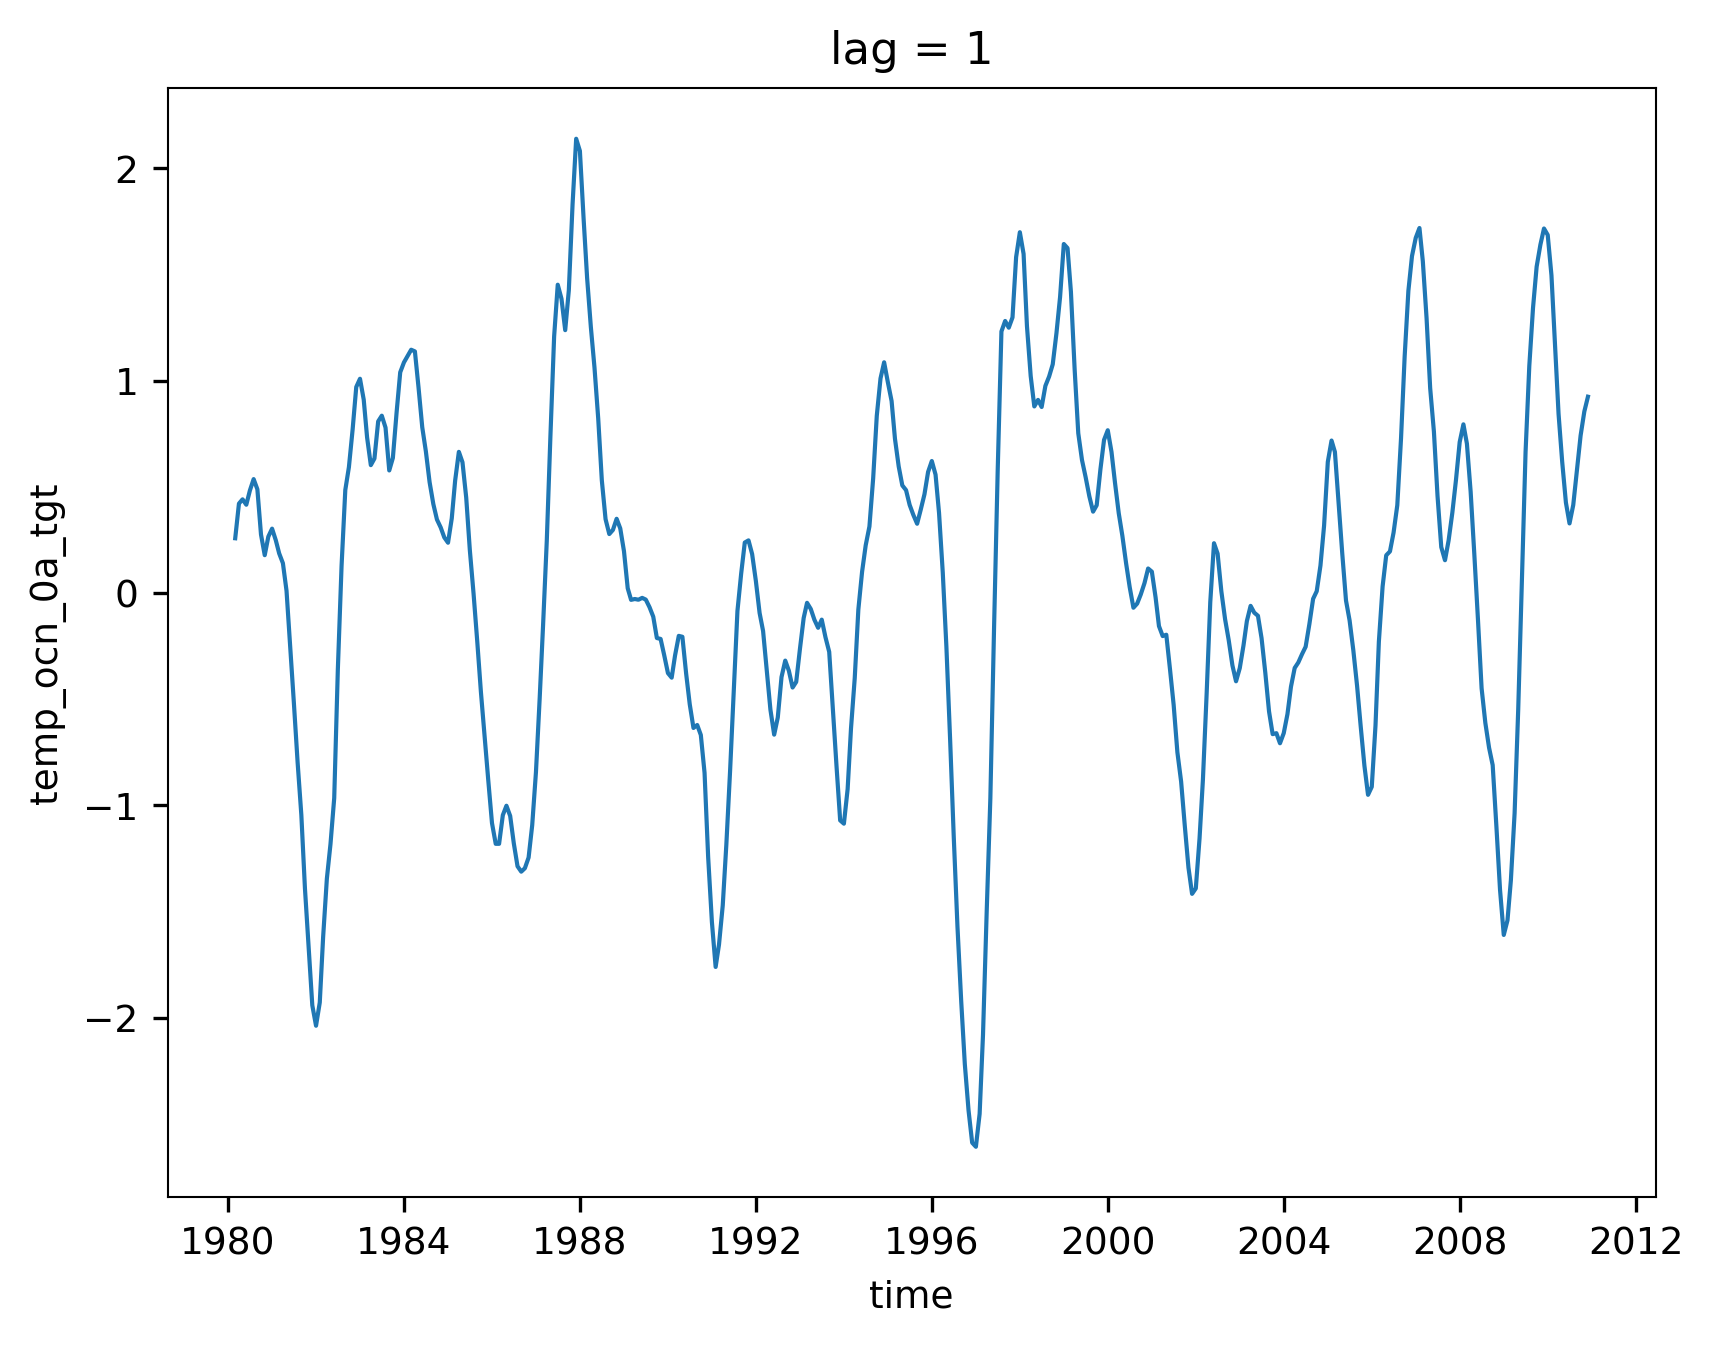

In [22]:
filtered_tgt_nino4.isel(lag = 0).plot()

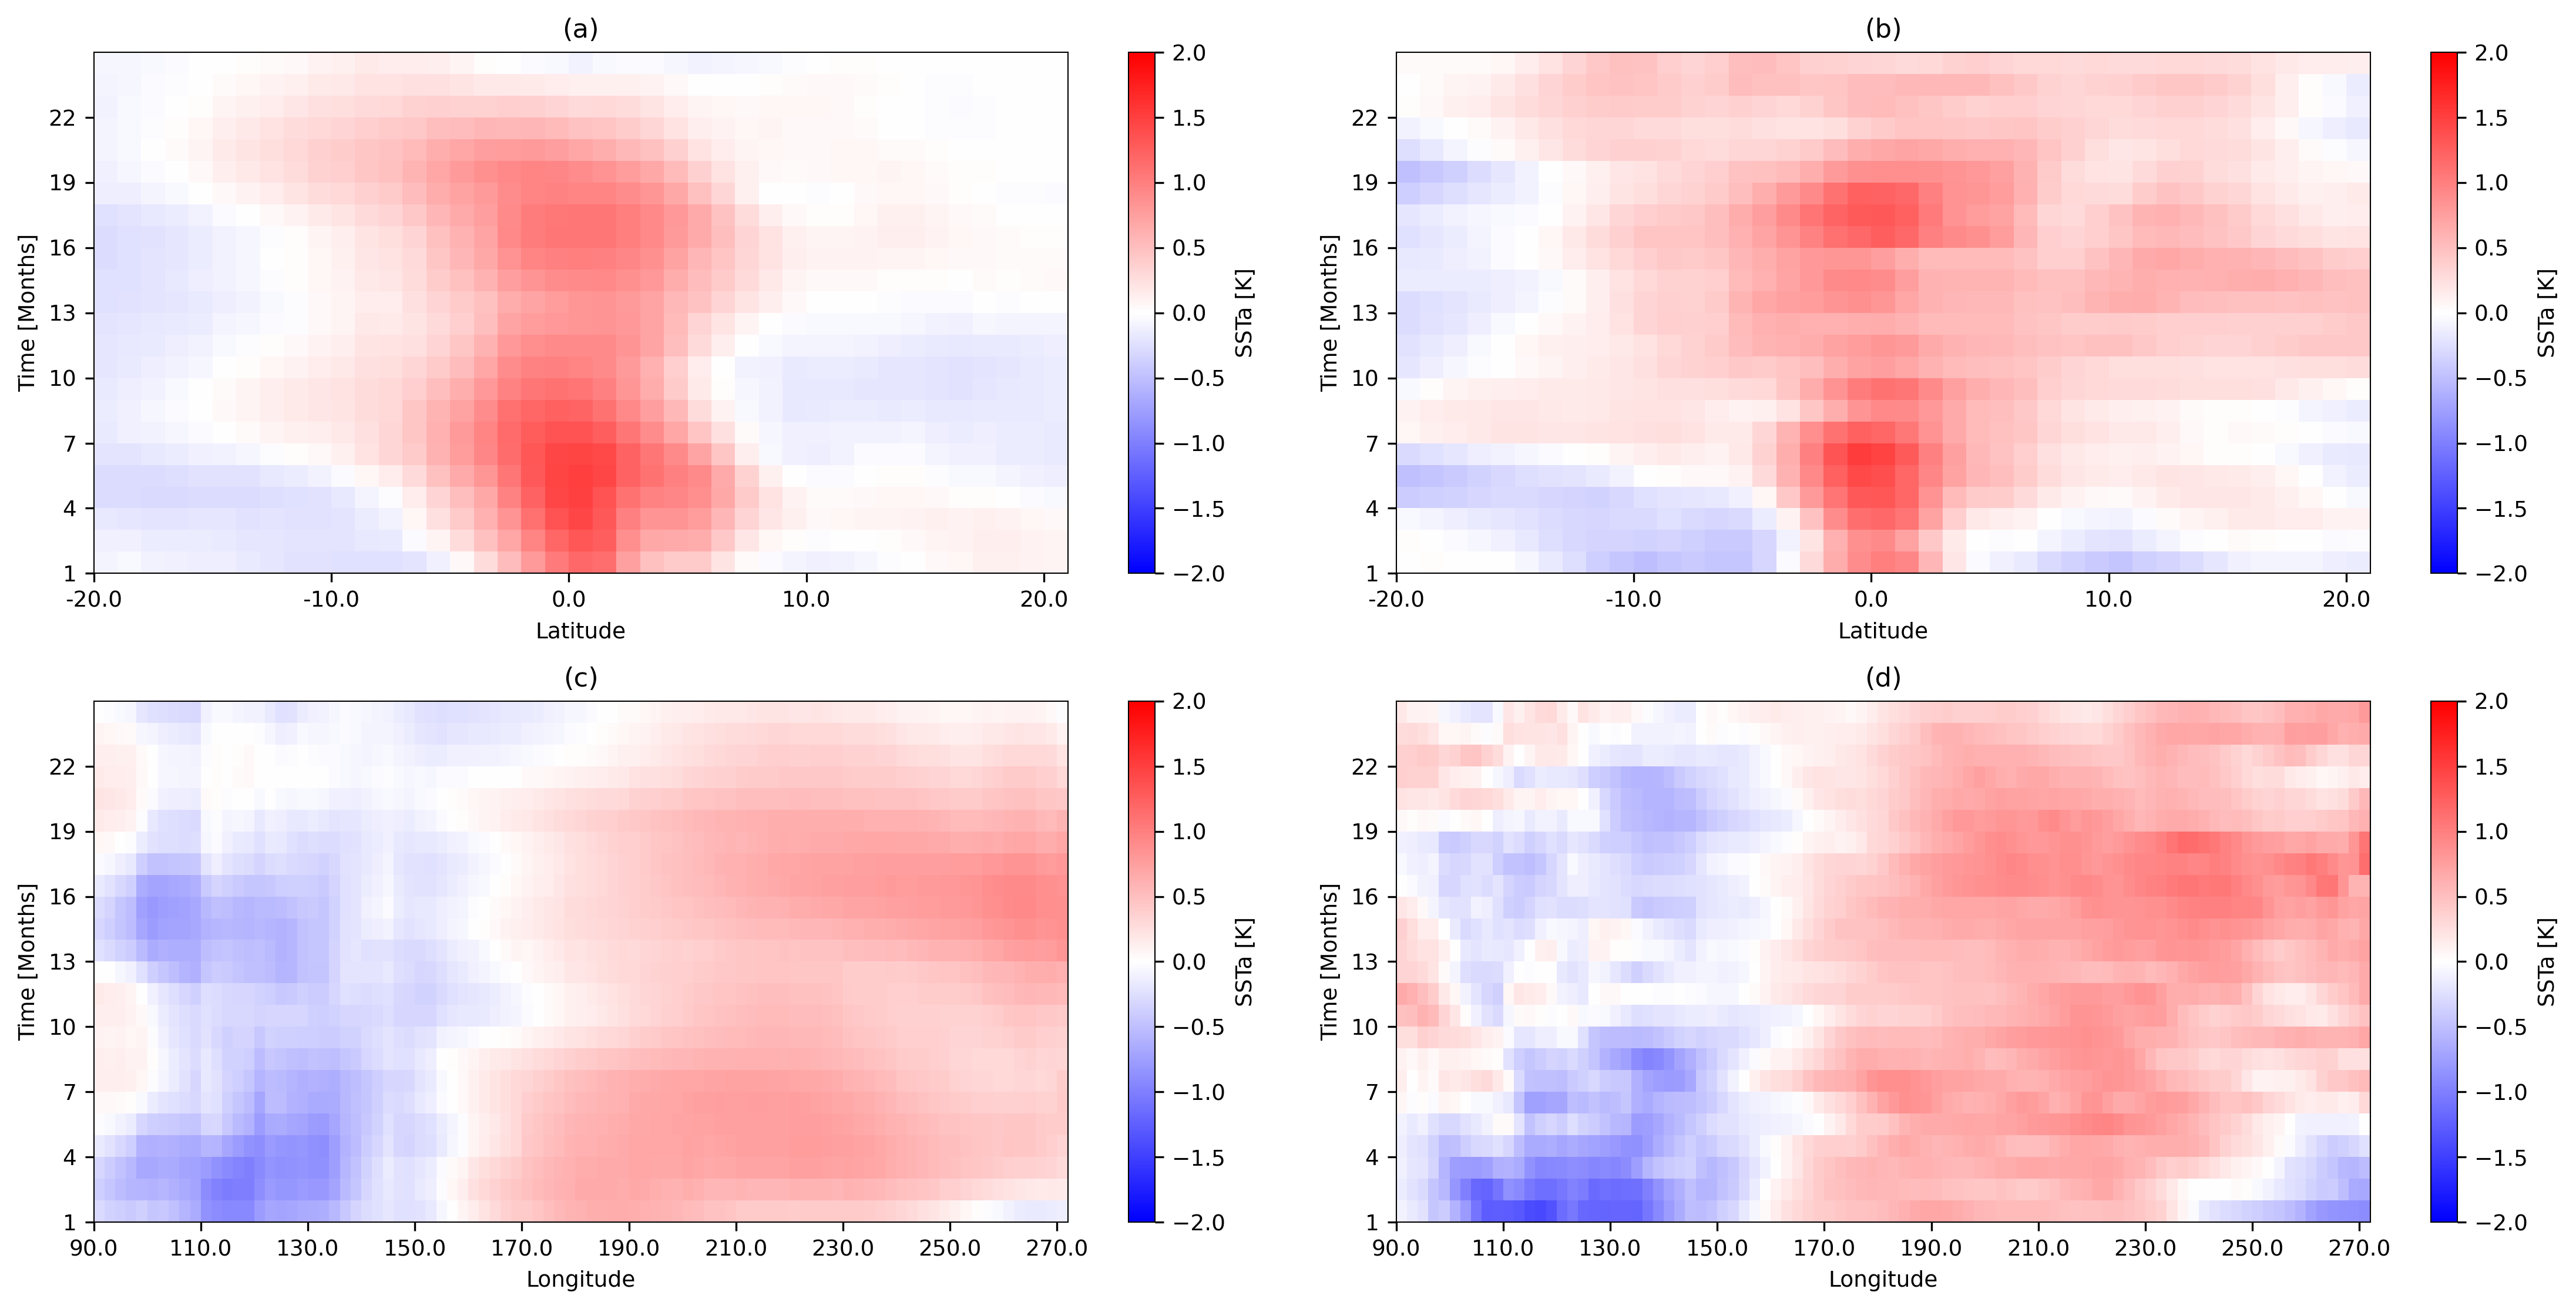

In [23]:
#example Hovmöller diagrams
t = "1997-08-01"
lev = np.linspace(-2, 2, 21)
cmap = "bwr"

x = filtered_pred.sel(time=t).mean("ens")
y = filtered_tgt.sel(time=t)

plt.figure(figsize = (15, 7.5))
plt.subplot(2, 2, 1)
# zonal-average

filled = plt.pcolormesh(x.mean("lon"), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(filled, label = "SSTa [K]")
plt.title("(a)")
plt.xlabel("Latitude")
plt.ylabel("Time [Months]")
plt.xticks(np.arange(0, len(x["lat"]), 10), x["lat"].values[::10])
plt.yticks(np.arange(0, len(x["lag"]), 3), x["lag"].values[::3])
plt.subplot(2, 2, 2)
filled = plt.pcolormesh(y.mean("lon"), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(filled, label = "SSTa [K]")
plt.title("(b)")
plt.xlabel("Latitude")
plt.ylabel("Time [Months]")
plt.xticks(np.arange(0, len(x["lat"]), 10), x["lat"].values[::10])
plt.yticks(np.arange(0, len(x["lag"]), 3), x["lag"].values[::3])

plt.subplot(2, 2, 3)
# meridional-average
filled = plt.pcolormesh(x.mean("lat"), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(filled, label = "SSTa [K]")
plt.title("(c)")
plt.xlabel("Longitude")
plt.ylabel("Time [Months]")
plt.xticks(np.arange(0, len(x["lon"]), 10), x["lon"].values[::10])
plt.yticks(np.arange(0, len(x["lag"]), 3), x["lag"].values[::3])

plt.subplot(2, 2, 4)
filled = plt.pcolormesh(y.mean("lat"), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(filled, label = "SSTa [K]")
plt.title("(d)")
plt.xlabel("Longitude")
plt.ylabel("Time [Months]")
plt.xticks(np.arange(0, len(x["lon"]), 10), x["lon"].values[::10])
plt.yticks(np.arange(0, len(x["lag"]), 3), x["lag"].values[::3])
plt.tight_layout()
plt.savefig(f"hovmoller_{ds_n}.png")
plt.show()

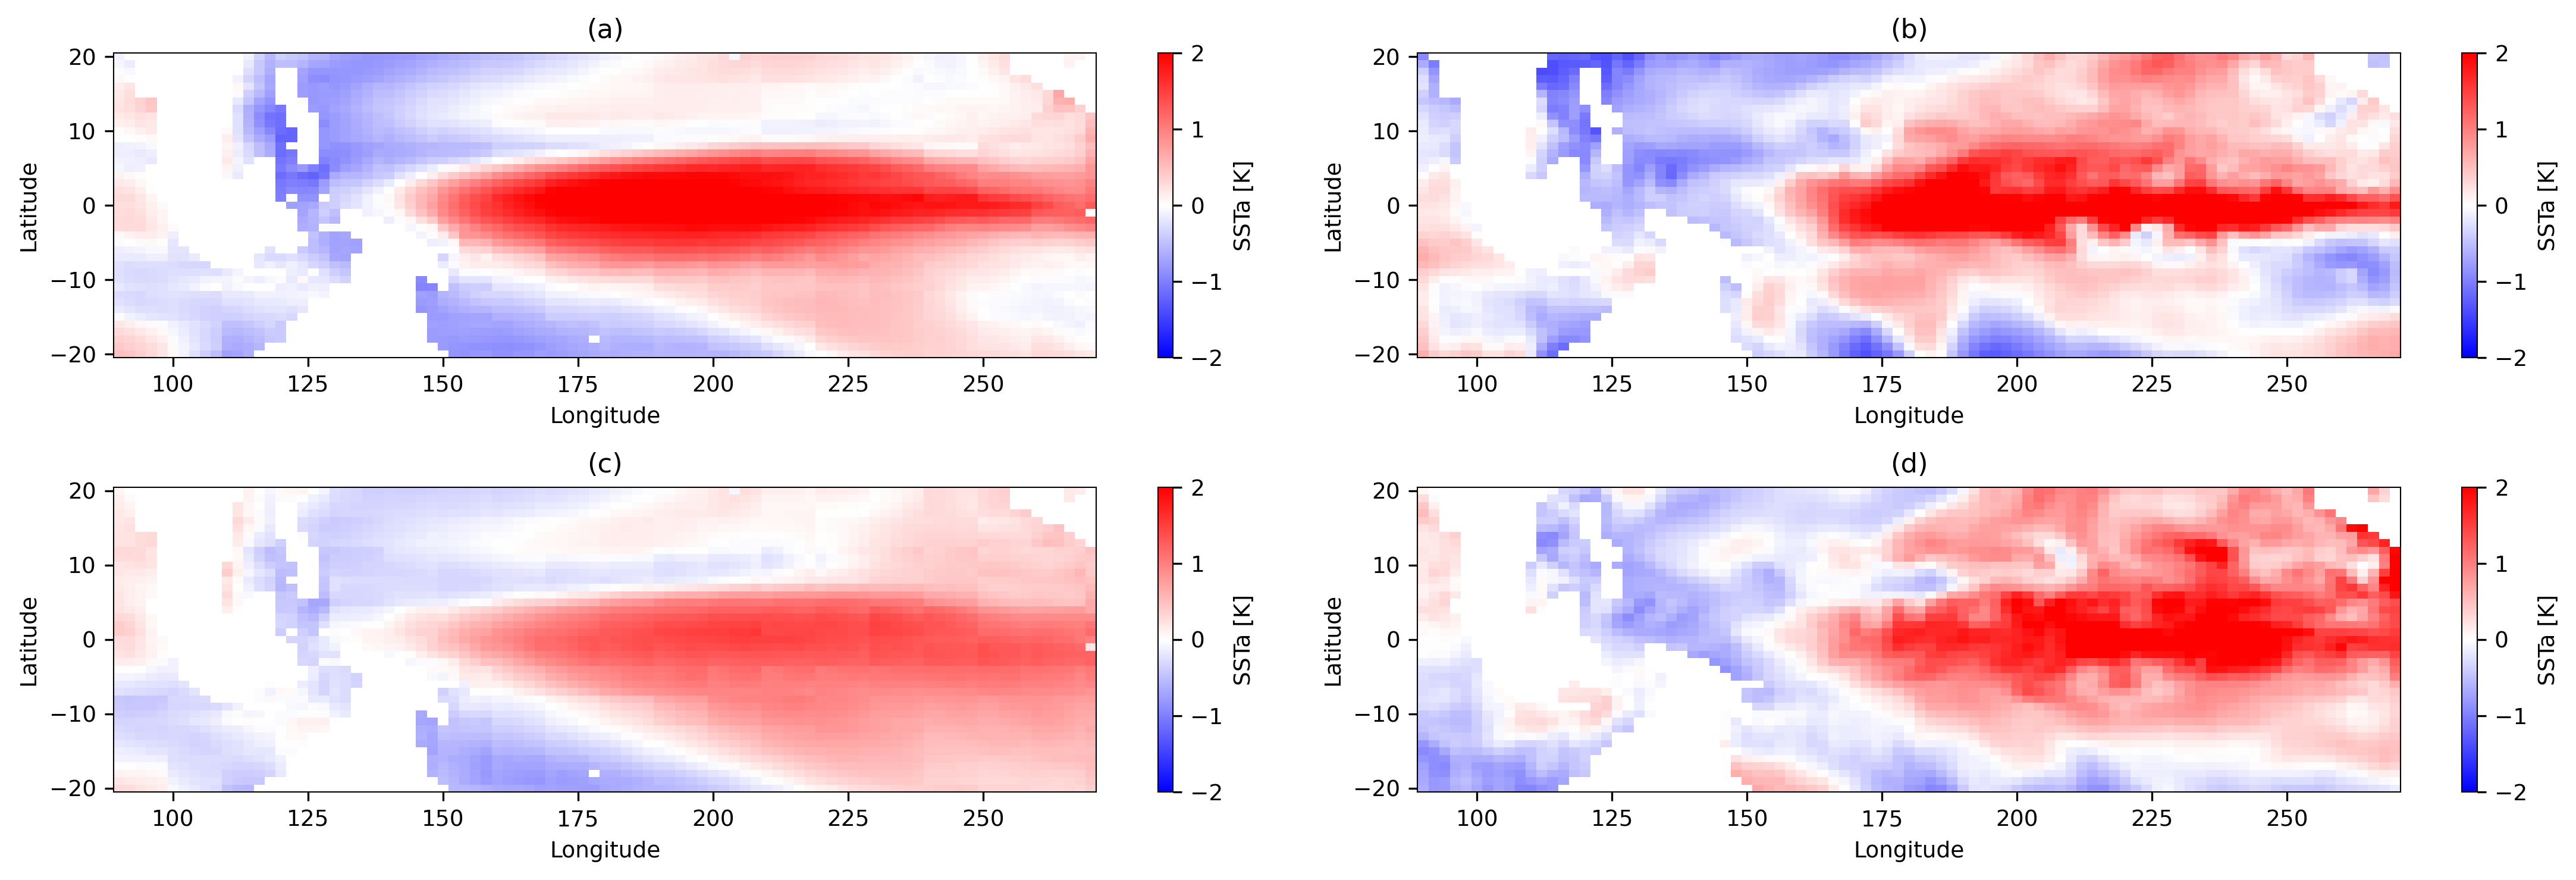

In [24]:
# example forecast plot

t1 = 6
t2 = 18
lev = np.linspace(-2, 2, 21)
cmap = "bwr"

x = filtered_pred.sel(time=t).mean("ens")
y = filtered_tgt.sel(time=t)

# 2 lead times: 6 and 18 months
plt.figure(figsize = (15, 5))
plt.subplot(2, 2, 1)
plt.pcolormesh(x.lon, x.lat, x.sel(lag = t1), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(label = "SSTa [K]")
plt.title("(a)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(2, 2, 2)
plt.pcolormesh(y.lon, y.lat, y.sel(lag = t1), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(label = "SSTa [K]")
plt.title("(b)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(2, 2, 3)
plt.pcolormesh(x.lon, x.lat, x.sel(lag = t2), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(label = "SSTa [K]")
plt.title("(c)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(2, 2, 4)
plt.pcolormesh(y.lon, y.lat, y.sel(lag = t2), cmap = cmap, vmin = -2, vmax = 2)
plt.colorbar(label = "SSTa [K]")
plt.title("(d)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.savefig(f"example_forecast_{ds_n}.png")
plt.show()

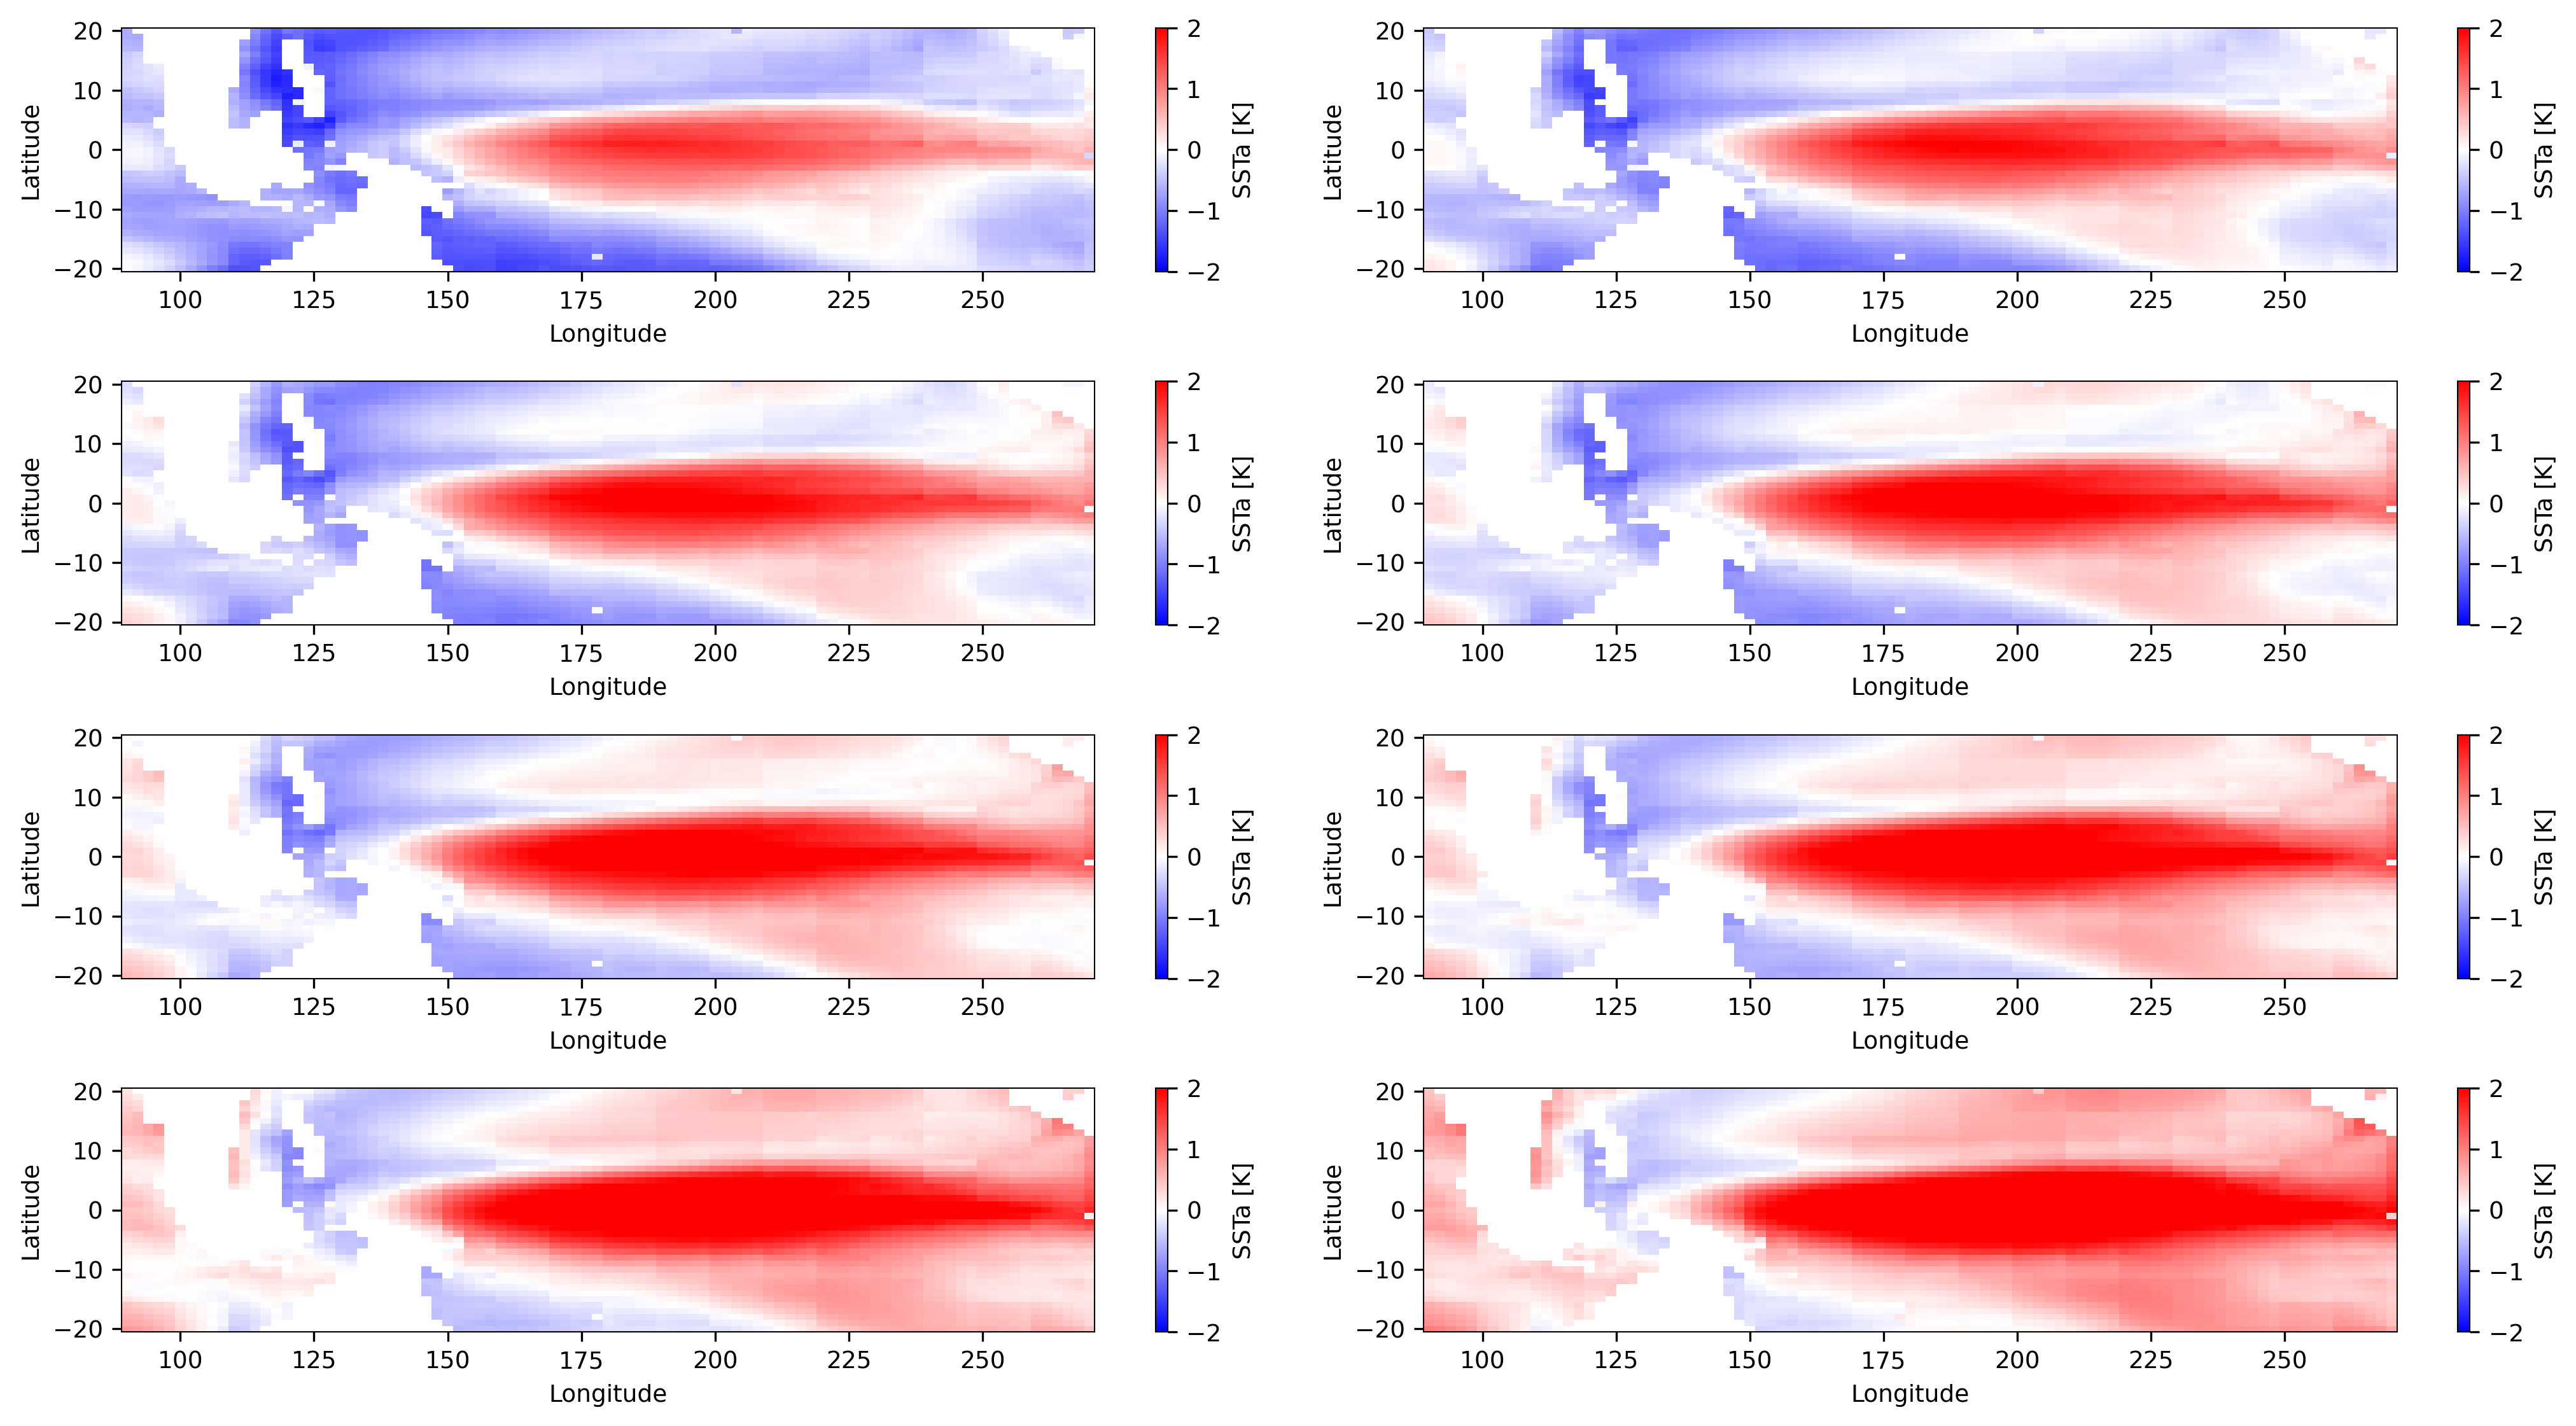

In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -- Example data setup ------------------------------------------------
# 'filtered_pred' must exist; assume it has dimensions [time, lag, lat, lon, ens].
# We'll extract x for time = t, lag = tau, then sort along ensemble dim:


x = filtered_pred.sel(time=t, lag=t1)
x = np.sort(x, axis=-1)
x = xr.DataArray(
    x,
    dims=["lat", "lon", "ens"],
    coords={
        "lat": filtered_pred.lat,
        "lon": filtered_pred.lon,
        "ens": np.arange(1, num_predictors + 1)
    }
)

# Calculate ensemble mean
x_mean = x.mean(dim="ens")

# -- Prepare data arrays for plotting (as NumPy) -----------------------
lat = x["lat"].values
lon = x["lon"].values

# For typical pcolormesh usage, ensure lat/lon are 1D. 
# If they're 2D, you'll need a slightly different approach with pcolormesh.
# We'll assume here lat and lon are 1D.
# (If they're 2D, consider using e.g. ax.pcolormesh(lon2d, lat2d, data, ...))

# -- Set up figure and subplot grid ------------------------------------
# We want 2 rows for the 8 ensemble members (4 each row) and
# 1 row (spanning all 4 columns) for the ensemble mean.
fig = plt.figure(figsize=(14, 9))  # adjust overall size to taste

# We create a GridSpec with 3 rows, 4 columns
#   row 0 -> 4 subplots (ens 0..3)
#   row 1 -> 4 subplots (ens 4..7)
#   row 2 -> 1 subplot (spans columns 0..4)
gs = gridspec.GridSpec(5, 2)  # adjust row height as needed

# Common plotting parameters
vmin, vmax = -2, 2
cmap = "bwr"

# -- Plot the 8 ensemble members ---------------------------------------
# Each ensemble member is shown in an individual subplot
for i_ens in range(8):
    # Determine row and column index based on ensemble member index
    row = i_ens // 2
    col = i_ens % 2
    ax = fig.add_subplot(gs[row, col])
    
    # Extract data for ensemble member (as NumPy array)
    data_ens = x.isel(ens=i_ens).values  # shape [lat, lon]
    
    # pcolormesh with shading='auto' to avoid warning about dimensions
    im = ax.pcolormesh(lon, lat, data_ens,
                       vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
    
    # Set aspect ratio (height:width = 1:2 => aspect=0.5)
    #ax.set_aspect(0.5)
    
    # Axis labels (for each subplot, you could omit some if it’s too crowded)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Remove the title (or simply do not set it)
    ax.set_title("")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("SSTa [K]")

# -- Final layout adjustments ------------------------------------------
plt.tight_layout()
plt.savefig(f"ensemble_members_{ds_n}.png")
plt.show()


In [26]:
nino4_tgt = filtered_tgt.sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()
nino4_pred = filtered_pred.sel(lon=slice(160, 210), lat=slice(-5, 5)).rolling(time = 3).mean()

if "ens" in nino4_pred.dims:
    nino4_pred = xr.DataArray(data = np.sort(nino4_pred, axis = -1).mean(axis=(-2, -3)), 
                              dims = ["time", "lag", "ens"], 
                              coords = {"time": nino4_tgt.time, "ens": np.arange(num_predictors), "lag": np.arange(1, 25)})
    nino4_mean = nino4_pred.mean("ens")
    nino4_var = nino4_pred.var("ens").mean(dim = ["time"])
else:
    nino4_mean = nino4_pred.mean(dim=['lon', 'lat'])
    nino4_var = (filtered_std.sel(lon=slice(160, 210), lat=slice(-5, 5)) ** 2).mean(dim=['lon', 'lat', 'time'])

rmse_nino4 = np.sqrt(((nino4_tgt - nino4_mean)**2).mean(["time"]))
clim_rmse_nino4 = np.sqrt(((nino4_tgt)**2).mean(["time"]))
acc_nino4 = (nino4_tgt* nino4_mean).sum(["time"]) / (((nino4_tgt**2).sum(["time"]) ** 0.5) * ((nino4_mean**2).sum(["time"])**0.5))
ssr_nino4 = np.sqrt(nino4_var) / (rmse_nino4 - np.sqrt(nino4_var / num_predictors))

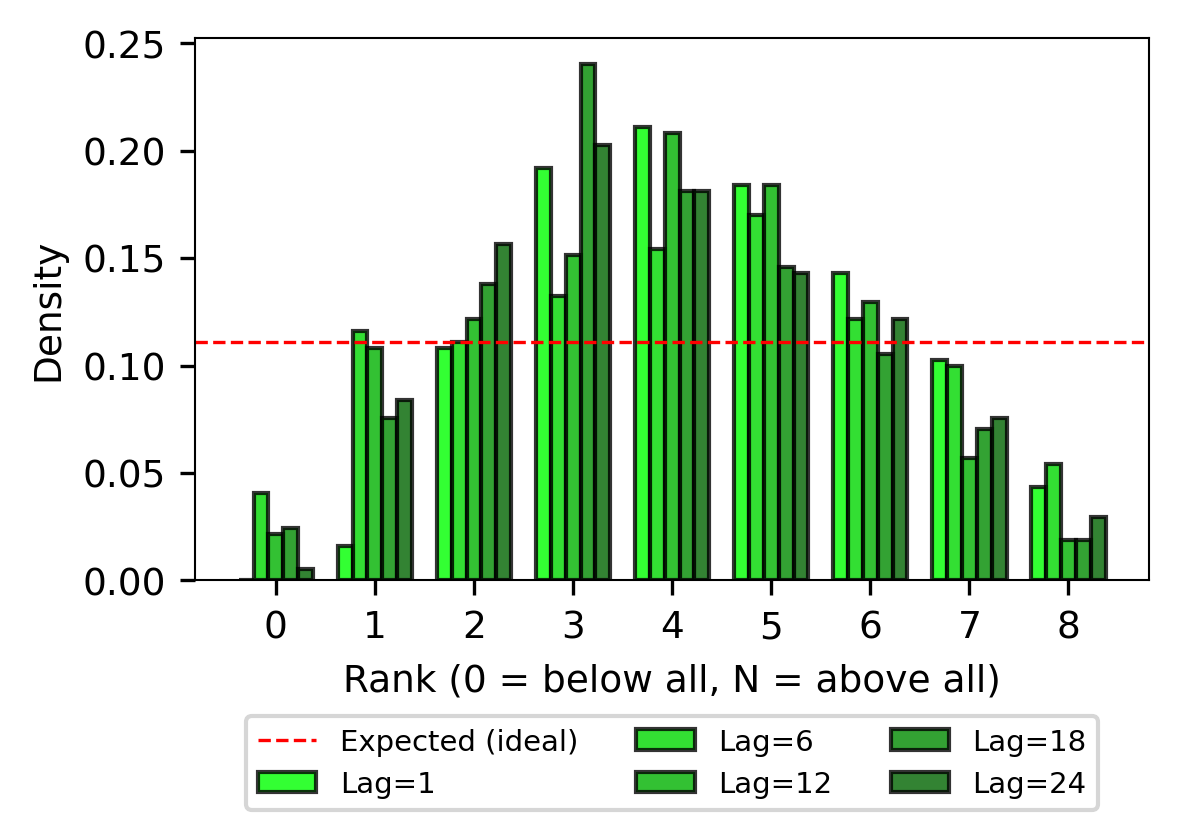

In [27]:
# --- Minimal CHANGES relative to your original approach ---
import matplotlib.colors as mcolors

# 2) Define the lags you want to plot
lags_to_plot = [1, 6, 12, 18, 24]
n = len(lags_to_plot)

# 3) Create a color gradient from bright green (#00FF00) to dark green (#006400)
bright_hex = '#00FF00'
dark_hex   = '#006400'

green_gradient = []
for idx in range(n):
    alpha = idx / (n - 1)  # Goes from 0 to 1 as we move through lags
    # Linear interpolation between bright_green and dark_green
    green = [
        (1 - alpha) * mcolors.to_rgb(bright_hex)[ch] + alpha * mcolors.to_rgb(dark_hex)[ch]
        for ch in range(3)
    ]
    green_gradient.append(mcolors.to_hex(green))

# 2) Create a single figure and axis
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust as needed

# 3) Loop over each representative lag and plot on the same axis
width = 0.15  # Bar width offset (adjust so bars don’t overlap)
colors = green_gradient  # Use the green gradient defined above

for i, lag_val in enumerate(lags_to_plot):
    # Select data for this lag
    obs_da_lag = nino4_tgt.sel(lag=lag_val)
    ens_da_lag = nino4_pred.sel(lag=lag_val).transpose("time", "ens")
    
    # Convert to numpy
    obs = obs_da_lag.values
    ens = ens_da_lag.values
    
    # Mask NaNs
    valid_mask = (~np.isnan(obs)) & (~np.isnan(ens).any(axis=1))
    obs_valid = obs[valid_mask]
    ens_valid = ens[valid_mask, :]
    
    # Compute rank histogram
    rank_counts = compute_rank_histogram(obs_valid, ens_valid)
    N = ens_valid.shape[1]  # number of ensemble members
    bins = np.arange(N + 1)
    
    # Offset each lag’s bars horizontally: bins + i*width
    ax.bar(bins + i * width,
           rank_counts,
           width=width,
           alpha=0.8,
           color=colors[i],
           edgecolor="black",
           label=f"Lag={lag_val}")

# 4) Final formatting
ax.set_ylabel("Density")
ax.set_xlabel("Rank (0 = below all, N = above all)")

# Optionally draw a reference line for a uniform distribution
# The expected count for a perfectly flat histogram:
expected_count = rank_counts.sum() / (N + 1)
ax.axhline(expected_count, color="red", linestyle="dashed", linewidth=0.8,
           label="Expected (ideal)")

# Position x-ticks in the middle of each "cluster"
ax.set_xticks(bins + (len(lags_to_plot)-1)*width/2)
ax.set_xticklabels(bins)

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)


plt.tight_layout()
plt.savefig(f"rank_histogram_nino4_{ds_n}.png")
plt.show()


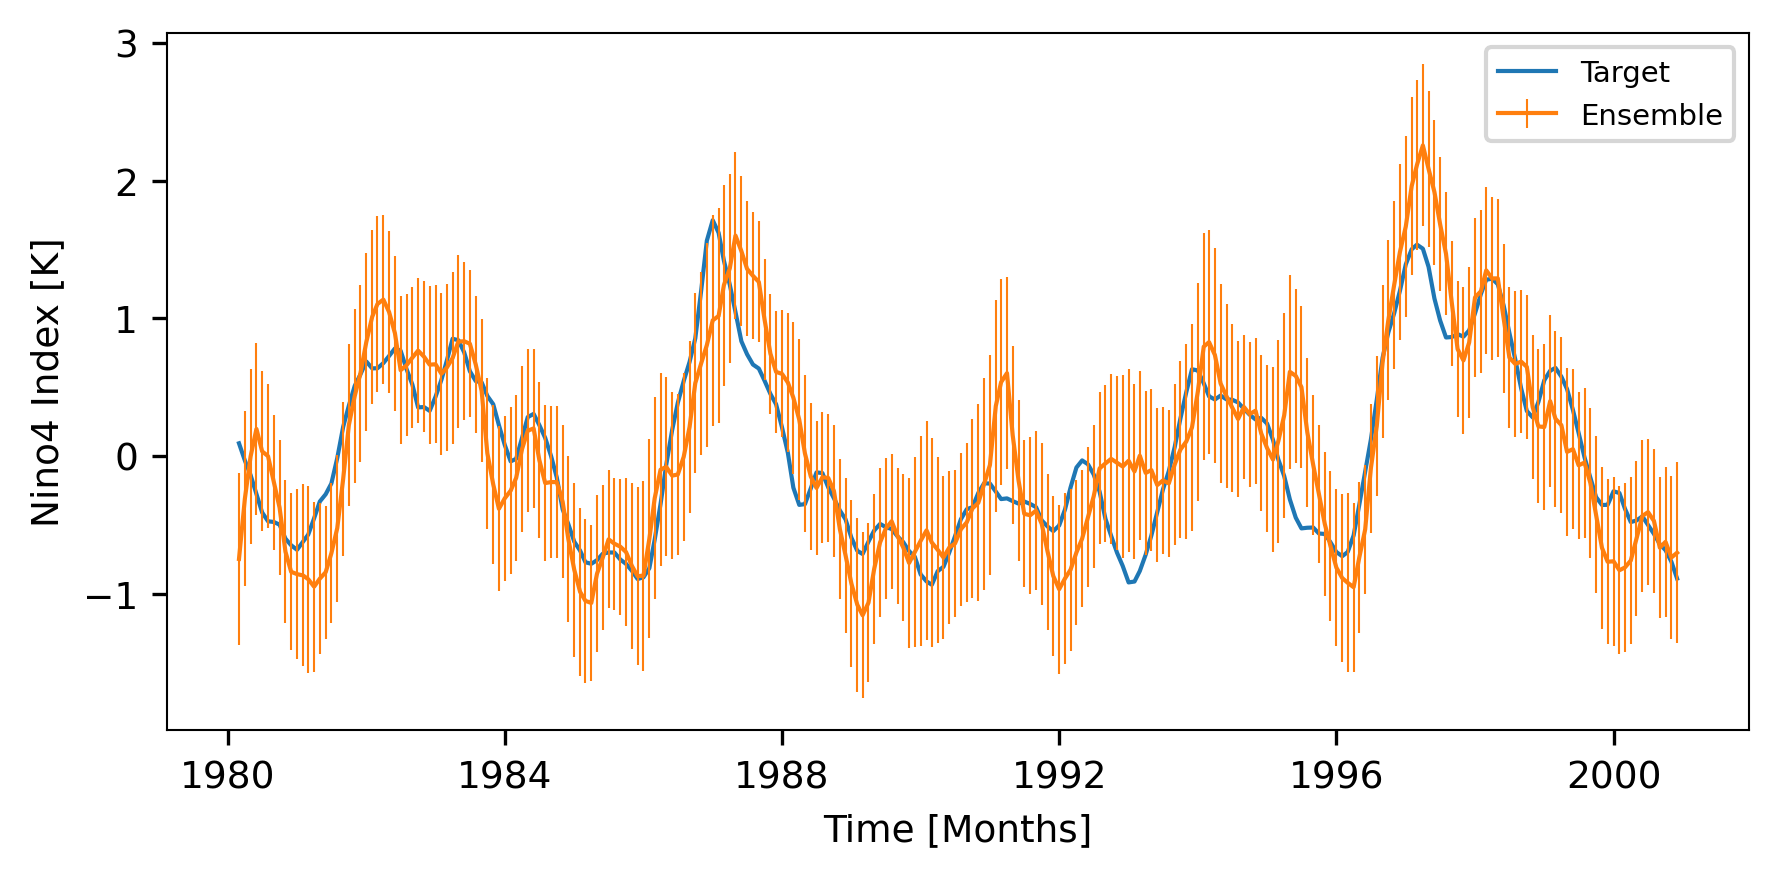

In [28]:
tau = 12
ensemble_prediction = nino4_pred.sel(lag = tau, time = slice("1980", "2000"))
plt.figure(figsize=(6,3))
plt.plot(ensemble_prediction.time.values, nino4_tgt.sel(lag = tau, time = slice("1980", "2000")), label = "Target")
plt.errorbar(ensemble_prediction.time.values, 
             ensemble_prediction.values.mean(axis = -1), 
             yerr = ensemble_prediction.values.std(axis = -1), label = "Ensemble", elinewidth=0.5)
plt.legend()
plt.xlabel("Time [Months]")
plt.ylabel("Nino4 Index [K]")
plt.tight_layout()
plt.savefig(f"nino4_timeseries_{ds_n}.png")
plt.show()

In [29]:
geoformer_acc = [0.994,0.963,0.931,0.9,0.87,0.843,0.816,0.789,0.768,0.748,0.732,0.718,0.703,0.677,0.652,0.624,0.592,0.557,0.512,0.455]
geoformer_rmse = [0.104,0.167,0.23,0.295,0.339,0.38,0.41,0.427,0.445,0.459,0.467,0.481,0.504,0.527,0.537,0.553,0.592,0.622,0.637,0.672]

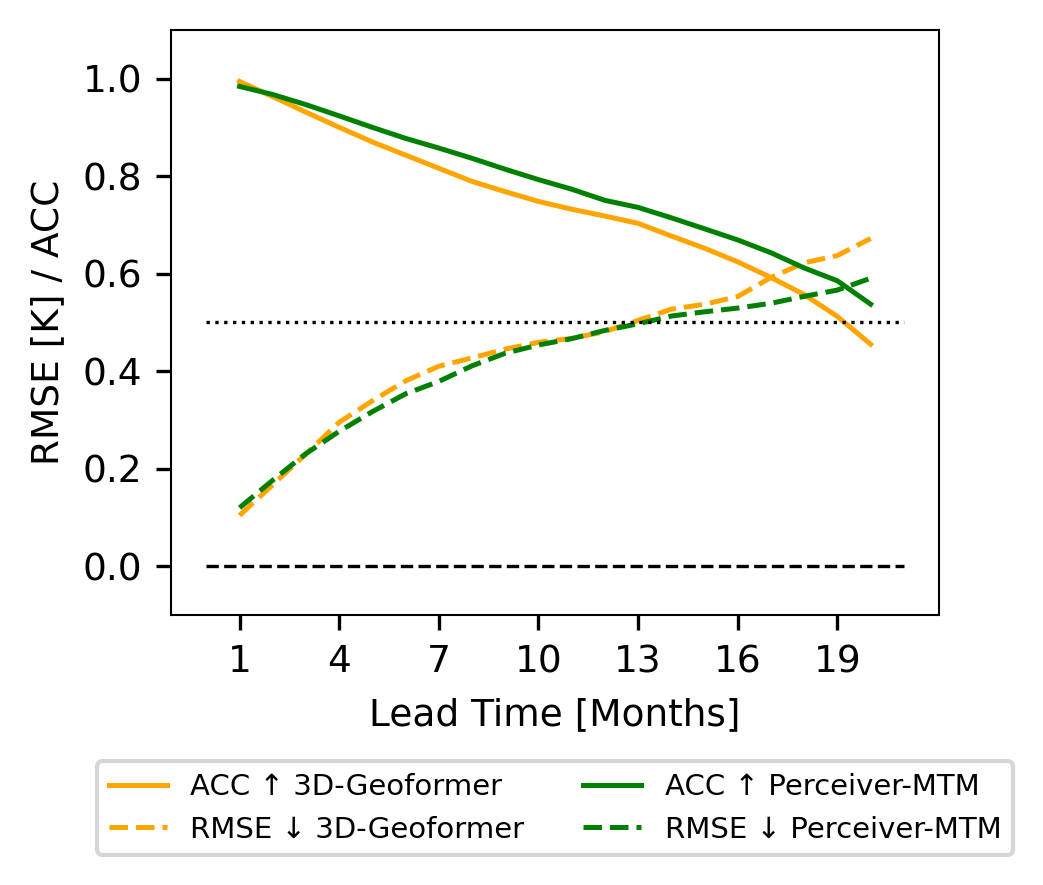

In [30]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(3.3, 2.5))  # Adjust size as needed; 3.3x2.5 for single-column

# Plot the data
ax.plot(np.arange(1, 21),
        geoformer_acc,
        label="ACC \u2191 3D-Geoformer",
        color="orange",
        linewidth=1.2)  # Slightly thicker than default

ax.plot(np.arange(1, 21),
        geoformer_rmse,
        label="RMSE \u2193 3D-Geoformer",
        color="orange",
        linestyle="--",
        linewidth=1.2)

ax.plot(np.arange(1, 21),
        acc_nino4[:20],
        label="ACC \u2191 Perceiver-MTM",
        color="green",
        linewidth=1.2)

ax.plot(np.arange(1, 21),
        rmse_nino4[:20],
        label="RMSE \u2193 Perceiver-MTM",
        color="green",
        linestyle="--",
        linewidth=1.2)

# Reference lines
ax.hlines(0.5, 0, 21, color="black", linestyle="dotted", linewidth=0.8)
ax.hlines(0, 0, 21, color="black", linestyle="dashed", linewidth=0.8)

# Axes limits and ticks
ax.set_ylim(-0.1, 1.1)
ax.set_xticks(np.arange(1, 22, 3))

# Labels (no in-figure title; use a caption in your paper)
ax.set_xlabel("Lead Time [Months]")
ax.set_ylabel("RMSE [K] / ACC")

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)

# Tight layout so labels fit well
#plt.tight_layout()

# Save or show the figure
# For publication, you might save as PDF or EPS:
plt.savefig(f"nino4_geoformer_{ds_n}.png", bbox_inches='tight')
plt.show()


In [31]:
import os

files = os.listdir('saved_scores')

datasets = [xr.open_dataset('saved_scores/' + f) for f in files]
names = [f.split('.')[0] for f in files]

datasets = {name: ds for name, ds in zip(names, datasets)}

print(datasets.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'saved_scores'

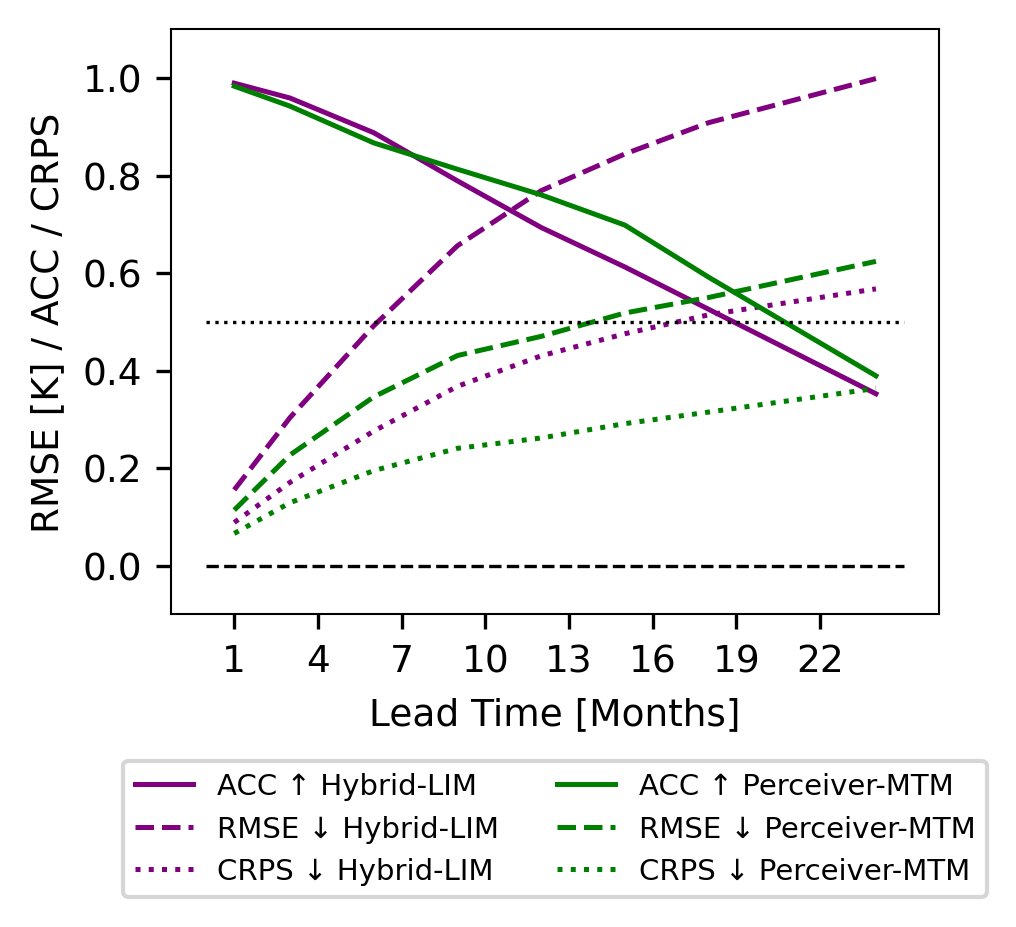

In [44]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(3.3, 2.5))  # Adjust size as needed; 3.3x2.5 for single-column

lag = datasets["corr"].lag.values
# Plot the data
ax.plot(lag, datasets["corr"].nino4.mean("member"),
        label="ACC \u2191 Hybrid-LIM",
        color="purple",
        linewidth=1.2)  # Slightly thicker than default

ax.plot(lag, datasets["rmse"].nino4.mean("member"),
        label="RMSE \u2193 Hybrid-LIM",
        color="purple",
        linestyle="--",
        linewidth=1.2)

ax.plot(lag, datasets["crps"].nino4.mean("member"),
        label="CRPS \u2193 Hybrid-LIM",
        color="purple",
        linestyle=":",
        linewidth=1.2)


ax.plot(lag,
        monthly_nino_accs.mean("month").sel(lag = lag),
        label="ACC \u2191 Perceiver-MTM",
        color="green",
        linewidth=1.2)

ax.plot(lag,
        monthly_nino_rmse.mean("month").sel(lag = lag),
        label="RMSE \u2193 Perceiver-MTM",
        color="green",
        linestyle="--",
        linewidth=1.2)

ax.plot(lag,
        monthly_nino_crps.mean("month").sel(lag = lag),
        label="CRPS \u2193 Perceiver-MTM",
        color="green",
        linestyle=":",
        linewidth=1.2)

# Reference lines
ax.hlines(0.5, 0, 25, color="black", linestyle="dotted", linewidth=0.8)
ax.hlines(0, 0, 25, color="black", linestyle="dashed", linewidth=0.8)

# Axes limits and ticks
ax.set_ylim(-0.1, 1.1)
ax.set_xticks(np.arange(1, 25, 3))

# Labels (no in-figure title; use a caption in your paper)
ax.set_xlabel("Lead Time [Months]")
ax.set_ylabel("RMSE [K] / ACC / CRPS")

# Legend
fig.subplots_adjust(bottom=0.1)

# Create a legend with multiple columns, aligned horizontally below the x-axis
# loc='upper center' + bbox_to_anchor=(0.5, -0.2) 
#   places the legend center at x=0.5 horizontally,
#   and below the plot (negative y).
# borderaxespad=0.0 sets minimal extra padding.
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    borderaxespad=0.0,
    frameon=True  # remove the bounding box if you prefer
)

# Tight layout so labels fit well
#plt.tight_layout()

# Save or show the figure
# For publication, you might save as PDF or EPS:
plt.savefig(f"nino4_lim_{ds_n}.png", bbox_inches='tight')
plt.show()
